In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pickle import dump, load
import os
from sklearn.linear_model import LinearRegression
from skimage.io import imread, imshow
from skimage.transform import resize

from keras.layers import Dense, Activation
from keras.models import Sequential
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

Using TensorFlow backend.


In [3]:
# load data
with open('data/all_trajs_zeroed.p', 'r') as f:
    all_trajs_zeroed = load(f)
    
with open('data/all_trajs_raw.p', 'r') as f:
    all_trajs_raw = load(f)

with open('data/train_test_ids.p', 'r') as f:
    train_test_ids = load(f)
    
with open('data/use_sets.p', 'r') as f:
    use_set = load(f)

In [42]:
# processing data into autoregression chunks
use_trajs = all_trajs_raw
train_trajs = np.take(use_trajs[7], train_test_ids[7]['train'], axis=0)    
test_trajs = np.take(use_trajs[7], train_test_ids[7]['test'], axis=0)

In [74]:
T_i = 5
T_o = 5
subsample = 3
X_tr, Y_tr, X_t, Y_t = [], [], [], []

In [75]:
for j, train_traj in enumerate(train_trajs):
    if j not in use_set['train']:
        continue
    for k in range(subsample):
        inds = np.arange(k, len(train_traj), subsample)
        for i in range(len(inds) - T_i - T_o):
            X_tr.append(np.take(train_traj, inds[i:i+T_i], axis=0).flatten())
            Y_tr.append(np.take(train_traj, inds[i+T_i:i+T_i+T_o], axis=0).flatten())
X_tr = np.array(X_tr)
Y_tr = np.array(Y_tr)

In [76]:
for j, test_traj in enumerate(test_trajs):
    if j not in use_set['train']:
        continue
    for k in range(subsample):
        inds = np.arange(k, len(test_traj), subsample)
        for i in range(len(inds) - T_i - T_o):
            X_t.append(np.take(test_traj, inds[i:i+T_i], axis=0).flatten())
            Y_t.append(np.take(test_traj, inds[i+T_i:i+T_i+T_o], axis=0).flatten())
X_t = np.array(X_t)
Y_t = np.array(Y_t)

### 3: Linear model

In [77]:
# linear regression on T-step zeroed trajs for cars
lin = LinearRegression(n_jobs=4)
lin.fit(X_tr, Y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [78]:
lin.score(X_t, Y_t)

0.96700072777823698

### 4: NN Model

In [79]:
nn= Sequential()
nn.add(Dense(input_dim=2 * T_i, units=100, activation='relu'))
nn.add(Dense(input_dim=100, units=50, activation='relu'))
nn.add(Dense(input_dim=50, units=2 * T_o, activation='linear'))
nn.compile(loss='mse', optimizer='adam', metrics=['mape'])

In [80]:
nn.fit(X_tr, Y_tr, batch_size=64, epochs=20, verbose=0, validation_split=0.2, callbacks=[TQDMNotebookCallback()])

### Generating new trajs

In [81]:
def gen_traj(model, init, T_i, T_o, T):
    traj = init.reshape(T_i, 2).tolist()    
    for i in range(T):
        try:
            seg = model.predict([np.array(traj[i:i+T_o]).flatten()])
        except:
            seg = model.predict(np.array(traj[i:i+T_o]).reshape(1,-1))
        x = seg.reshape(T_i, 2).tolist()[0]
        traj.append(x)
    return np.array(traj)

In [82]:
def unzero_traj(traj, i, class_id, is_train=True):
    # find original id from train_test_ids
    id = train_test_ids[class_id]['train'][i] if is_train else train_test_ids[class_id]['test'][i]

    # get the first value from raw traj
    zero = all_trajs_raw[class_id][id][0]

    # reconstruct new raw traj
    unzeroed_traj = traj + zero
    
    return unzeroed_traj

In [83]:
street_raw = imread('/nfs/diskstation/jren/projection_average.png')
street = street_raw[97:719, 510:1132][:,:,:3]
street = resize(street, [1000,1000])

In [ ]:
for i, seed in enumerate(use_trajs[7]):
    try:
        traj_pred = gen_traj(nn, seed[:T_i].reshape(1,-1), T_i, T_o, 30)
    except:
        continue
    plt.figure(figsize=(10,10))
    plt.imshow(street)
    plt.scatter(traj_pred[:,0], traj_pred[:,1])
    plt.savefig('ims/nn_gens/{}.png'.format(i))

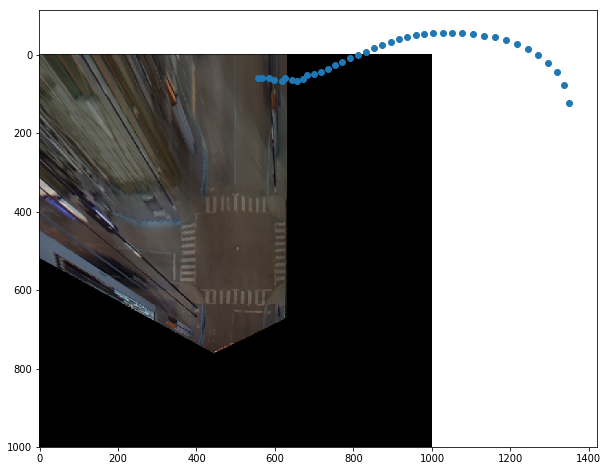

In [41]:
traj_pred_zero = gen_traj(nn, X_tr[n], T_i, T_o, 30)
traj_pred = unzero_traj(traj_pred_zero, n, 7, True)
plt.figure(figsize=(10,10))
plt.imshow(street)
plt.scatter(traj_pred[:,0], traj_pred[:,1])
plt.show()

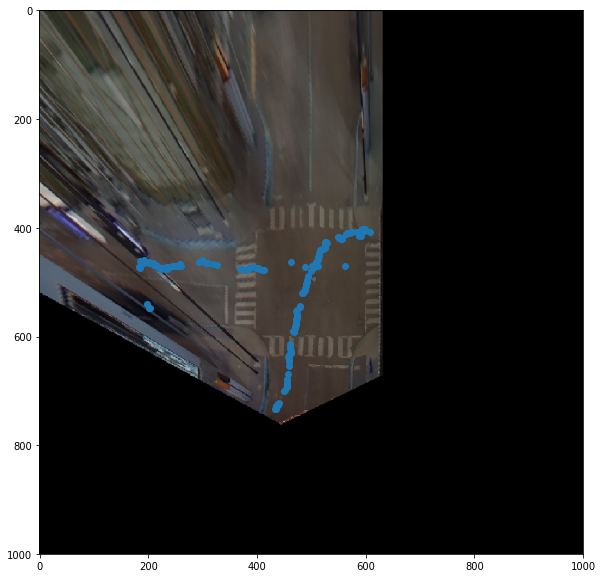

In [220]:
plt.figure(figsize=(10,10))
for k in range(len(train_trajs)):
    plt.clf()
    kth_traj = unzero_traj(train_trajs[k], k, 7, True)
    plt.imshow(street)
    plt.scatter(kth_traj[:,0], kth_traj[:,1])
    plt.savefig('ims/train/{}.png'.format(k))

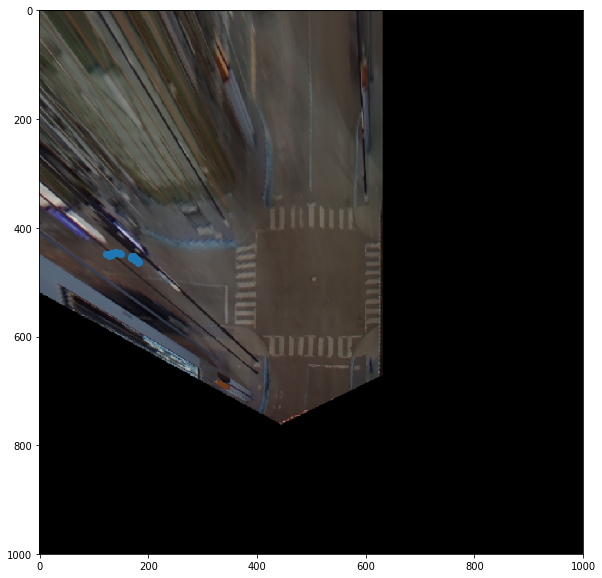

In [221]:
plt.figure(figsize=(10,10))
for k in range(len(test_trajs)):
    plt.clf()
    kth_traj = unzero_traj(test_trajs[k], k, 7, True)
    plt.imshow(street)
    plt.scatter(kth_traj[:,0], kth_traj[:,1])
    plt.savefig('ims/test/{}.png'.format(k))

In [229]:
use_sets= {
    'train':set(),
    'test':set()
}

In [230]:
for path in os.listdir('ims/train'):
    use_sets['train'].add(int(path[:-4]))

In [231]:
for path in os.listdir('ims/test'):
    use_sets['test'].add(int(path[:-4]))

In [232]:
with open('data/use_sets.p', 'w') as f:
    dump(use_sets, f)